In [93]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/forecast/market_lookup_table.csv
/kaggle/input/forecast/prescriber_data.csv
/kaggle/input/forecast/patient_claims_data.csv
/kaggle/input/forecast/calendar_table.csv
/kaggle/input/forecast-exp-3/calendar.csv
/kaggle/input/forecast-exp-3/claims.csv
/kaggle/input/forecast-exp-3/prescribers.csv
/kaggle/input/forecast-exp-3/market.csv
/kaggle/input/forecast-expanded/market_expanded.csv
/kaggle/input/forecast-expanded/prescribers_expanded.csv
/kaggle/input/forecast-expanded/calendar_expanded.csv
/kaggle/input/forecast-expanded/claims_expanded.csv


In [94]:
import pandas as pd
import numpy as np
from datetime import datetime
from pathlib import Path
current_dir = Path.cwd()
print("Current directory:", current_dir)

Current directory: /kaggle/working


In [95]:
import os
base_path = "/kaggle/input/"
print(os.listdir(base_path))

['forecast', 'forecast-exp-3', 'forecast-expanded']


In [96]:

import pandas as pd
base_path = "/kaggle/input/forecast/"
market = pd.read_csv(base_path + "market_lookup_table.csv")
prescribers = pd.read_csv(base_path + "prescriber_data.csv")
claims = pd.read_csv(base_path + "patient_claims_data.csv")
calendar = pd.read_csv(base_path + "calendar_table.csv")



In [97]:

print("=== Market Lookup Data ===")
print(market.columns.tolist())
print(market.head(), "\n")

print("=== Prescribers Data ===")
print(prescribers.columns.tolist())
print(prescribers.head(), "\n")

print("=== Claims Data ===")
print(claims.columns.tolist())
print(claims.head(), "\n")

print("=== Calendar Data ===")
print(calendar.columns.tolist())
print(calendar.head(), "\n")


=== Market Lookup Data ===
['brand_name', 'molecule', 'therapeutic_class']
  brand_name    molecule therapeutic_class
0     Drug_A  Molecule_0           Class_A
1     Drug_B  Molecule_1           Class_B
2     Drug_C  Molecule_2           Class_C
3     Drug_D  Molecule_3           Class_A
4     Drug_E  Molecule_4           Class_B 

=== Prescribers Data ===
['hcp_id', 'specialty', 'brand_written', 'region']
    hcp_id      specialty brand_written region
0  HCP7311  Endocrinology        Drug_E  South
1  HCP4114        General        Drug_E  South
2  HCP5173      Neurology        Drug_E   East
3  HCP1727      Neurology        Drug_E   West
4  HCP8144     Cardiology        Drug_C  North 

=== Claims Data ===
['patient_id', 'ndc_code', 'drug_name', 'start_date', 'end_date', 'days_supply', 'provider_id', 'specialty', 'diagnosis_code', 'region']
  patient_id    ndc_code drug_name  start_date    end_date  days_supply  \
0     P23104  51904-9849    Drug_B  2022-05-12  2022-07-11           60  

In [98]:
calendar.head(1)

,date,month,year,fiscal_quarter,fiscal_year
0,2022-01-01,1,2022,1,2022


In [99]:
claims.head(1)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region
0,P23104,51904-9849,Drug_B,2022-05-12,2022-07-11,60,HCP3414,General,D654,East


In [100]:
claims.head(5)
claims['start_date'] = pd.to_datetime(claims['start_date']).dt.date
claims_sorted=claims.sort_values(by=['patient_id','start_date'])
claims_sorted.head(2)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region
1193,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South
1937,P10074,29769-4788,Drug_D,2022-06-26,2022-09-24,90,HCP7790,General,D123,North


In [101]:
claims_sorted['previous_end'] = claims_sorted.groupby('patient_id')['end_date'].shift(1)
claims_sorted.head(2)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region,previous_end
1193,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South,NaN
1937,P10074,29769-4788,Drug_D,2022-06-26,2022-09-24,90,HCP7790,General,D123,North,2022-07-05


In [102]:
claims_sorted['gap_days']=pd.to_datetime(claims_sorted['start_date'])-pd.to_datetime(claims_sorted['previous_end'])
claims_sorted['gap_days'] = claims_sorted['gap_days'].dt.days
claims_sorted['gap_days'] = claims_sorted['gap_days'].fillna(-1)
claims_sorted.head(2)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region,previous_end,gap_days
1193,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South,NaN,-1.0
1937,P10074,29769-4788,Drug_D,2022-06-26,2022-09-24,90,HCP7790,General,D123,North,2022-07-05,-9.0


In [103]:
claims_sorted['new_start'] = (claims_sorted['gap_days'] > 180).astype(int)
claims_sorted.head(2)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region,previous_end,gap_days,new_start
1193,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South,NaN,-1.0,0
1937,P10074,29769-4788,Drug_D,2022-06-26,2022-09-24,90,HCP7790,General,D123,North,2022-07-05,-9.0,0


In [104]:
claims_sorted['last_med_date'] = claims_sorted.groupby('patient_id')['end_date'].transform('max')
claims_sorted['last_med_date']=claims_sorted.groupby('patient_id')['end_date'].transform('max')
claims_sorted.head(2)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region,previous_end,gap_days,new_start,last_med_date
1193,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South,NaN,-1.0,0,2024-10-12
1937,P10074,29769-4788,Drug_D,2022-06-26,2022-09-24,90,HCP7790,General,D123,North,2022-07-05,-9.0,0,2024-10-12


In [105]:
from datetime import datetime
claims_sorted['todays_date'] = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))

In [106]:
claims_sorted['last_med_days_count']=pd.to_datetime(claims_sorted['todays_date'])-pd.to_datetime(claims_sorted['last_med_date'])
claims_sorted['last_med_days_count'] = claims_sorted['last_med_days_count'].dt.days
claims_sorted['last_med_days_count'] = claims_sorted['last_med_days_count'].fillna(-1)
claims_sorted.head(2)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region,previous_end,gap_days,new_start,last_med_date,todays_date,last_med_days_count
1193,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South,NaN,-1.0,0,2024-10-12,2025-10-02,355
1937,P10074,29769-4788,Drug_D,2022-06-26,2022-09-24,90,HCP7790,General,D123,North,2022-07-05,-9.0,0,2024-10-12,2025-10-02,355


In [107]:
claims_sorted['discontinued'] = (claims_sorted['last_med_days_count'] > 365).astype(int)

In [108]:
print("Total patients :",claims_sorted['patient_id'].nunique())
print("New start patients :",claims_sorted[claims_sorted['new_start'] == 1]['patient_id'].nunique())
print("Discounted patients :",claims_sorted[claims_sorted['discontinued'] == 1]['patient_id'].nunique())
print("New and Discounted patients :",claims_sorted[(claims_sorted['new_start'] == 1) & (claims_sorted['discontinued'] == 1)]['patient_id'].nunique())

Total patients : 497
New start patients : 390
Discounted patients : 210
New and Discounted patients : 144


In [109]:
row_count = len(claims_sorted)
row_count
row_count = claims_sorted.shape[0]
row_count
claims_sorted.head(3)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region,previous_end,gap_days,new_start,last_med_date,todays_date,last_med_days_count,discontinued
1193,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South,NaN,-1.0,0,2024-10-12,2025-10-02,355,0
1937,P10074,29769-4788,Drug_D,2022-06-26,2022-09-24,90,HCP7790,General,D123,North,2022-07-05,-9.0,0,2024-10-12,2025-10-02,355,0
1038,P10074,51904-9849,Drug_B,2022-07-29,2022-08-28,30,HCP6344,General,D456,South,2022-09-24,-57.0,0,2024-10-12,2025-10-02,355,0


In [110]:
market_distinct = market.drop_duplicates()
print("Market rows:",len(market))
print("Market distinct rows:",len(market_distinct))
market_distinct.head(2)

Market rows: 5
Market distinct rows: 5


,brand_name,molecule,therapeutic_class
0,Drug_A,Molecule_0,Class_A
1,Drug_B,Molecule_1,Class_B


In [111]:
claims_sorted.head(2)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region,previous_end,gap_days,new_start,last_med_date,todays_date,last_med_days_count,discontinued
1193,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South,NaN,-1.0,0,2024-10-12,2025-10-02,355,0
1937,P10074,29769-4788,Drug_D,2022-06-26,2022-09-24,90,HCP7790,General,D123,North,2022-07-05,-9.0,0,2024-10-12,2025-10-02,355,0


In [112]:
claims_merged = claims_sorted.merge(
    market_distinct,
    how='left',
    left_on='drug_name',
    right_on='brand_name'
)

In [113]:
claims_merged.head(2)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region,previous_end,gap_days,new_start,last_med_date,todays_date,last_med_days_count,discontinued,brand_name,molecule,therapeutic_class
0,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South,NaN,-1.0,0,2024-10-12,2025-10-02,355,0,Drug_C,Molecule_2,Class_C
1,P10074,29769-4788,Drug_D,2022-06-26,2022-09-24,90,HCP7790,General,D123,North,2022-07-05,-9.0,0,2024-10-12,2025-10-02,355,0,Drug_D,Molecule_3,Class_A


In [114]:
claims_switch_base=claims_merged[['patient_id','drug_name','molecule','start_date','end_date','previous_end','gap_days','new_start','last_med_date','discontinued']]

In [115]:
len(claims_switch_base)

3000

In [116]:
len(claims_sorted)

3000

In [117]:
claims_switch_base.head(5)

,patient_id,drug_name,molecule,start_date,end_date,previous_end,gap_days,new_start,last_med_date,discontinued
0,P10074,Drug_C,Molecule_2,2022-04-06,2022-07-05,NaN,-1.0,0,2024-10-12,0
1,P10074,Drug_D,Molecule_3,2022-06-26,2022-09-24,2022-07-05,-9.0,0,2024-10-12,0
2,P10074,Drug_B,Molecule_1,2022-07-29,2022-08-28,2022-09-24,-57.0,0,2024-10-12,0
3,P10074,Drug_E,Molecule_4,2022-11-23,2023-02-21,2022-08-28,87.0,0,2024-10-12,0
4,P10074,Drug_C,Molecule_2,2023-08-21,2023-11-19,2023-02-21,181.0,1,2024-10-12,0


In [118]:
claim_sb_2=claims_switch_base
claim_sb_2['previous_molecule'] = (
    claims_switch_base
    .groupby('patient_id')['molecule']
    .shift(1)
)

/tmp/ipykernel_149/2728594592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claim_sb_2['previous_molecule'] = (


In [119]:
claim_sb_2.head(10)

,patient_id,drug_name,molecule,start_date,end_date,previous_end,gap_days,new_start,last_med_date,discontinued,previous_molecule
0,P10074,Drug_C,Molecule_2,2022-04-06,2022-07-05,NaN,-1.0,0,2024-10-12,0,NaN
1,P10074,Drug_D,Molecule_3,2022-06-26,2022-09-24,2022-07-05,-9.0,0,2024-10-12,0,Molecule_2
2,P10074,Drug_B,Molecule_1,2022-07-29,2022-08-28,2022-09-24,-57.0,0,2024-10-12,0,Molecule_3
3,P10074,Drug_E,Molecule_4,2022-11-23,2023-02-21,2022-08-28,87.0,0,2024-10-12,0,Molecule_1
4,P10074,Drug_C,Molecule_2,2023-08-21,2023-11-19,2023-02-21,181.0,1,2024-10-12,0,Molecule_4
5,P10074,Drug_A,Molecule_0,2023-10-04,2023-11-03,2023-11-19,-46.0,0,2024-10-12,0,Molecule_2
6,P10074,Drug_D,Molecule_3,2024-06-04,2024-07-04,2023-11-03,214.0,1,2024-10-12,0,Molecule_0
7,P10074,Drug_E,Molecule_4,2024-06-07,2024-08-06,2024-07-04,-27.0,0,2024-10-12,0,Molecule_3
8,P10074,Drug_B,Molecule_1,2024-07-04,2024-08-03,2024-08-06,-33.0,0,2024-10-12,0,Molecule_4
9,P10074,Drug_A,Molecule_0,2024-09-12,2024-10-12,2024-08-03,40.0,0,2024-10-12,0,Molecule_1


In [120]:
import numpy as np
claim_sb_2['switch_flag'] = np.where(claim_sb_2['molecule']==claim_sb_2['previous_molecule'], 0, 1)
claim_sb_2

/tmp/ipykernel_149/687086356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claim_sb_2['switch_flag'] = np.where(claim_sb_2['molecule']==claim_sb_2['previous_molecule'], 0, 1)


,patient_id,drug_name,molecule,start_date,end_date,previous_end,gap_days,new_start,last_med_date,discontinued,previous_molecule,switch_flag
0,P10074,Drug_C,Molecule_2,2022-04-06,2022-07-05,NaN,-1.0,0,2024-10-12,0,NaN,1
1,P10074,Drug_D,Molecule_3,2022-06-26,2022-09-24,2022-07-05,-9.0,0,2024-10-12,0,Molecule_2,1
2,P10074,Drug_B,Molecule_1,2022-07-29,2022-08-28,2022-09-24,-57.0,0,2024-10-12,0,Molecule_3,1
3,P10074,Drug_E,Molecule_4,2022-11-23,2023-02-21,2022-08-28,87.0,0,2024-10-12,0,Molecule_1,1
4,P10074,Drug_C,Molecule_2,2023-08-21,2023-11-19,2023-02-21,181.0,1,2024-10-12,0,Molecule_4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,P99593,Drug_D,Molecule_3,2024-08-27,2024-09-26,2024-02-03,206.0,1,2024-12-01,0,Molecule_3,0
2996,P99593,Drug_C,Molecule_2,2024-11-01,2024-12-01,2024-09-26,36.0,0,2024-12-01,0,Molecule_3,1
2997,P99733,Drug_E,Molecule_4,2023-07-28,2023-09-26,NaN,-1.0,0,2024-07-13,1,NaN,1
2998,P99733,Drug_D,Molecule_3,2023-12-24,2024-02-22,2023-09-26,89.0,0,2024-07-13,1,Molecule_4,1


In [121]:
claim_sb_2['switch_flag'] = np.where(
    claim_sb_2['previous_molecule'].isna(), 0,
    np.where(claim_sb_2['molecule'] == claim_sb_2['previous_molecule'], 0, 1)
)

/tmp/ipykernel_149/3058965538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claim_sb_2['switch_flag'] = np.where(


In [122]:
claim_sb_2.head(2)

,patient_id,drug_name,molecule,start_date,end_date,previous_end,gap_days,new_start,last_med_date,discontinued,previous_molecule,switch_flag
0,P10074,Drug_C,Molecule_2,2022-04-06,2022-07-05,NaN,-1.0,0,2024-10-12,0,NaN,0
1,P10074,Drug_D,Molecule_3,2022-06-26,2022-09-24,2022-07-05,-9.0,0,2024-10-12,0,Molecule_2,1


In [123]:
switch_summary = (
    claim_sb_2.groupby('patient_id')
    .agg(
        switch_count=('switch_flag', 'sum'),
        distinct_molecules=('molecule', 'nunique')
    )
    .reset_index()
)
print(switch_summary)

    patient_id  switch_count  distinct_molecules
0       P10074             9                   5
1       P10282             6                   4
2       P10425             6                   3
3       P10464             1                   2
4       P10851             8                   4
..         ...           ...                 ...
492     P99192             2                   2
493     P99353             3                   3
494     P99399             3                   3
495     P99593             4                   4
496     P99733             1                   2

[497 rows x 3 columns]


In [124]:
claims_sorted.head(2)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region,previous_end,gap_days,new_start,last_med_date,todays_date,last_med_days_count,discontinued
1193,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South,NaN,-1.0,0,2024-10-12,2025-10-02,355,0
1937,P10074,29769-4788,Drug_D,2022-06-26,2022-09-24,90,HCP7790,General,D123,North,2022-07-05,-9.0,0,2024-10-12,2025-10-02,355,0


In [125]:
patient_funnel_1=claims_sorted.groupby('patient_id').agg(initiation_date=('start_date','min'),last_fill_date=('end_date','max'),unique_drugs=('drug_name','nunique'),number_of_fills=('start_date','count')).reset_index()
patient_funnel_1

,patient_id,initiation_date,last_fill_date,unique_drugs,number_of_fills
0,P10074,2022-04-06,2024-10-12,5,10
1,P10282,2022-08-15,2025-02-19,4,8
2,P10425,2022-05-26,2024-11-22,3,8
3,P10464,2023-03-01,2024-06-28,2,2
4,P10851,2022-01-27,2024-12-15,4,10
...,...,...,...,...,...
492,P99192,2022-01-16,2024-10-20,2,5
493,P99353,2022-05-23,2024-10-18,3,5
494,P99399,2023-07-27,2025-01-12,3,4
495,P99593,2022-04-15,2024-12-01,4,6


In [126]:
patient_funnel_1['days_of_therapy']=pd.to_datetime(patient_funnel_1['last_fill_date'])-pd.to_datetime(patient_funnel_1['initiation_date'])
patient_funnel_1['days_of_therapy'] = patient_funnel_1['days_of_therapy'].dt.days
patient_funnel_1['days_of_therapy'] = patient_funnel_1['days_of_therapy'].fillna(-1)
patient_funnel_1

,patient_id,initiation_date,last_fill_date,unique_drugs,number_of_fills,days_of_therapy
0,P10074,2022-04-06,2024-10-12,5,10,920
1,P10282,2022-08-15,2025-02-19,4,8,919
2,P10425,2022-05-26,2024-11-22,3,8,911
3,P10464,2023-03-01,2024-06-28,2,2,485
4,P10851,2022-01-27,2024-12-15,4,10,1053
...,...,...,...,...,...,...
492,P99192,2022-01-16,2024-10-20,2,5,1008
493,P99353,2022-05-23,2024-10-18,3,5,879
494,P99399,2023-07-27,2025-01-12,3,4,535
495,P99593,2022-04-15,2024-12-01,4,6,961


In [127]:
import seaborn as sls
import matplotlib.pyplot as plt
patient_funnel_1

,patient_id,initiation_date,last_fill_date,unique_drugs,number_of_fills,days_of_therapy
0,P10074,2022-04-06,2024-10-12,5,10,920
1,P10282,2022-08-15,2025-02-19,4,8,919
2,P10425,2022-05-26,2024-11-22,3,8,911
3,P10464,2023-03-01,2024-06-28,2,2,485
4,P10851,2022-01-27,2024-12-15,4,10,1053
...,...,...,...,...,...,...
492,P99192,2022-01-16,2024-10-20,2,5,1008
493,P99353,2022-05-23,2024-10-18,3,5,879
494,P99399,2023-07-27,2025-01-12,3,4,535
495,P99593,2022-04-15,2024-12-01,4,6,961


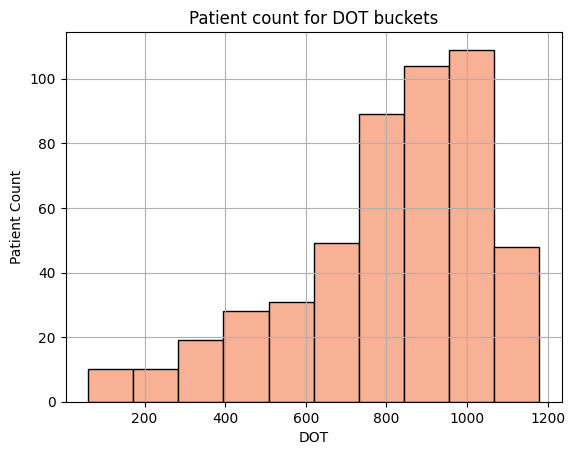

In [128]:
plt.hist(patient_funnel_1['days_of_therapy'], bins=10, edgecolor='black',color='#F8B195')
plt.title('Patient count for DOT buckets')
plt.xlabel('DOT')
plt.ylabel('Patient Count')
plt.grid(True)
plt.show()

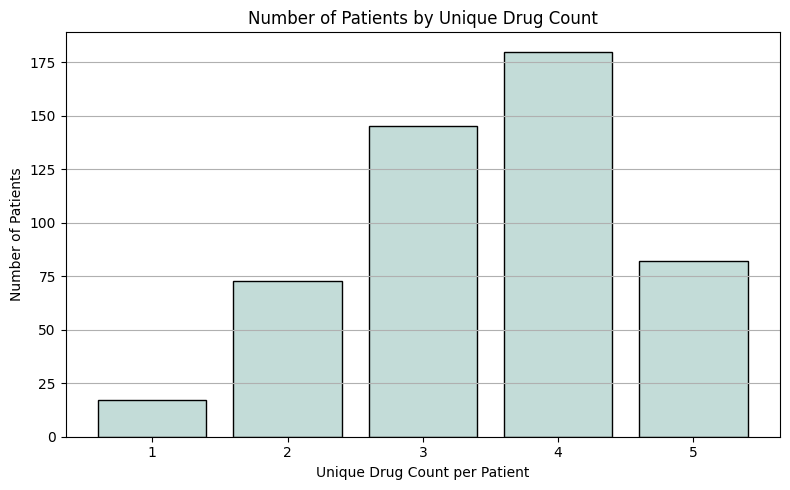

In [129]:
import matplotlib.pyplot as plt
pat_count_df = patient_funnel_1.groupby('unique_drugs').agg(pat_count=('patient_id', 'nunique')).reset_index()
plt.figure(figsize=(8, 5))
plt.bar(pat_count_df['unique_drugs'], pat_count_df['pat_count'], color='#C3DCD8', edgecolor='black')
plt.title('Number of Patients by Unique Drug Count')
plt.xlabel('Unique Drug Count per Patient')
plt.ylabel('Number of Patients')
plt.xticks(pat_count_df['unique_drugs'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [130]:
patient_funnel_2=patient_funnel_1[['unique_drugs','patient_id']]
patient_funnel_2=patient_funnel_2.groupby('unique_drugs').agg(pat_count=('patient_id','nunique')).reset_index()

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

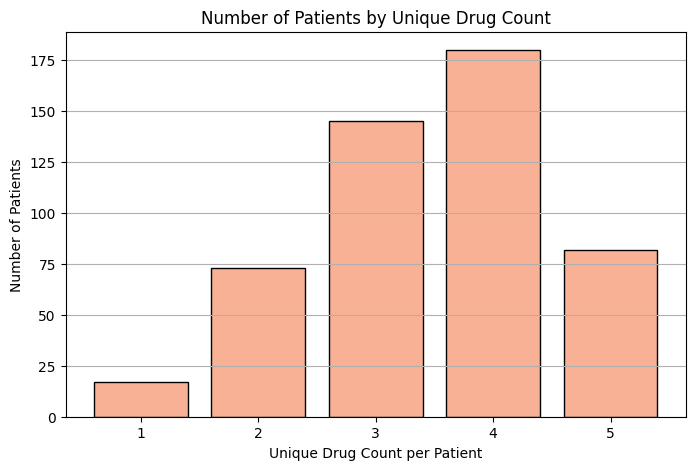

In [131]:
plt.figure(figsize=(8, 5))
plt.bar(patient_funnel_2['unique_drugs'], patient_funnel_2['pat_count'], color='#F8B195', edgecolor='black')
plt.title('Number of Patients by Unique Drug Count')
plt.xlabel('Unique Drug Count per Patient')
plt.ylabel('Number of Patients')
plt.grid(axis='y')
plt.tight_layout

In [132]:
type(claims_sorted)

pandas.core.frame.DataFrame

In [133]:
claim_fill_date = claims_sorted.groupby('patient_id').agg(fill_count=('start_date', 'count')).reset_index()
type(claim_fill_date)
claim_fill_date

,patient_id,fill_count
0,P10074,10
1,P10282,8
2,P10425,8
3,P10464,2
4,P10851,10
...,...,...
492,P99192,5
493,P99353,5
494,P99399,4
495,P99593,6


In [134]:
claim_fill_date = claims_sorted.groupby(['patient_id', 'start_date', 'end_date']).size().reset_index(name='fill_count')
claim_fill_date

,patient_id,start_date,end_date,fill_count
0,P10074,2022-04-06,2022-07-05,1
1,P10074,2022-06-26,2022-09-24,1
2,P10074,2022-07-29,2022-08-28,1
3,P10074,2022-11-23,2023-02-21,1
4,P10074,2023-08-21,2023-11-19,1
...,...,...,...,...
2992,P99593,2024-08-27,2024-09-26,1
2993,P99593,2024-11-01,2024-12-01,1
2994,P99733,2023-07-28,2023-09-26,1
2995,P99733,2023-12-24,2024-02-22,1


In [135]:
print(claim_fill_date.columns)
print(claim_fill_date.dtypes)
print(calendar.columns)
print(calendar.dtypes)

Index(['patient_id', 'start_date', 'end_date', 'fill_count'], dtype='object')
patient_id    object
start_date    object
end_date      object
fill_count     int64
dtype: object
Index(['date', 'month', 'year', 'fiscal_quarter', 'fiscal_year'], dtype='object')
date              object
month              int64
year               int64
fiscal_quarter     int64
fiscal_year        int64
dtype: object


In [136]:
claim_fill_date['start_date'] = pd.to_datetime(claim_fill_date['start_date'])
calendar['date'] = pd.to_datetime(calendar['date'])

In [137]:
claim_fill_month = claim_fill_date.merge(calendar, how='inner', left_on='start_date', right_on='date')
claim_fill_month.head(5)

,patient_id,start_date,end_date,fill_count,date,month,year,fiscal_quarter,fiscal_year
0,P10074,2022-04-06,2022-07-05,1,2022-04-06,4,2022,2,2022
1,P10074,2022-06-26,2022-09-24,1,2022-06-26,6,2022,2,2022
2,P10074,2022-07-29,2022-08-28,1,2022-07-29,7,2022,3,2022
3,P10074,2022-11-23,2023-02-21,1,2022-11-23,11,2022,4,2022
4,P10074,2023-08-21,2023-11-19,1,2023-08-21,8,2023,3,2023


In [138]:
claim_mm_yy=claim_fill_month.groupby(['month','year']).agg(fill_count=('start_date','count')).reset_index()

In [139]:
claim_mm_yy.head(2)

,month,year,fill_count
0,1,2022,92
1,1,2023,84


In [140]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [141]:
claim_mm_yy['month_start'] = pd.to_datetime(dict(year=claim_mm_yy.year, month=claim_mm_yy.month, day=1))
claim_mm_yy['fill_count'] = claim_mm_yy['fill_count'].interpolate(method='linear')
claim_mm_yy.head(2)

,month,year,fill_count,month_start
0,1,2022,92,2022-01-01
1,1,2023,84,2023-01-01


In [142]:
claim_mm_yy = claim_mm_yy.sort_values(by=['year', 'month'])
claims_ms=claim_mm_yy[['month_start','year','month','fill_count']].reset_index(drop=True)
claims_ms.head(2)

,month_start,year,month,fill_count
0,2022-01-01,2022,1,92
1,2022-02-01,2022,2,79


In [143]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
df = claims_ms.copy()
df = df.rename(columns={'month_start': 'ds', 'fill_count': 'y'})
df['ds'] = pd.to_datetime(df['ds'])
df.head(2)

,ds,year,month,y
0,2022-01-01,2022,1,92
1,2022-02-01,2022,2,79


In [144]:
df['y'] = df['y'].interpolate(method='linear')
df.head(2)

,ds,year,month,y
0,2022-01-01,2022,1,92
1,2022-02-01,2022,2,79


In [145]:
model = Prophet(seasonality_mode='multiplicative')
model.fit(df[['ds', 'y']])

22:09:58 - cmdstanpy - INFO - Chain [1] start processing
22:09:59 - cmdstanpy - INFO - Chain [1] done processing


In [146]:
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2022-01-01,85.533732,82.553351,100.978908,85.533732,85.533732,0.06772,0.06772,0.06772,0.06772,0.06772,0.06772,0.0,0.0,0.0,91.326051
1,2022-02-01,85.487288,67.375056,84.997945,85.487288,85.487288,-0.11208,-0.11208,-0.11208,-0.11208,-0.11208,-0.11208,0.0,0.0,0.0,75.905914


In [147]:
forecast.shape
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2022-01-01,85.533732,82.553351,100.978908,85.533732,85.533732,0.06772,0.06772,0.06772,0.06772,0.06772,0.06772,0.0,0.0,0.0,91.326051
1,2022-02-01,85.487288,67.375056,84.997945,85.487288,85.487288,-0.11208,-0.11208,-0.11208,-0.11208,-0.11208,-0.11208,0.0,0.0,0.0,75.905914


In [148]:
claims_ms.shape

(36, 4)

In [149]:
merged_df = forecast[['ds', 'yhat']].merge(df[['ds', 'y']], on='ds', how='left')
merged_df.head(2)

,ds,yhat,y
0,2022-01-01,91.326051,92.0
1,2022-02-01,75.905914,79.0


In [150]:
merged_df = merged_df[['ds', 'y', 'yhat']]
print(merged_df.tail(15))

           ds     y       yhat
33 2024-10-01  85.0  82.629033
34 2024-11-01  84.0  78.364770
35 2024-12-01  75.0  82.675628
36 2025-01-01   NaN  95.026997
37 2025-02-01   NaN  70.015632
38 2025-03-01   NaN  77.900485
39 2025-04-01   NaN  71.078164
40 2025-05-01   NaN  84.779551
41 2025-06-01   NaN  81.488639
42 2025-07-01   NaN  93.097859
43 2025-08-01   NaN  87.726552
44 2025-09-01   NaN  81.069170
45 2025-10-01   NaN  85.906701
46 2025-11-01   NaN  78.355648
47 2025-12-01   NaN  81.324851


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [151]:
masked_df = merged_df.copy()
masked_df.loc[masked_df['y'].notna(), 'yhat'] = None
masked_df.head(2)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ds,y,yhat
0,2022-01-01,92.0,NaN
1,2022-02-01,79.0,NaN


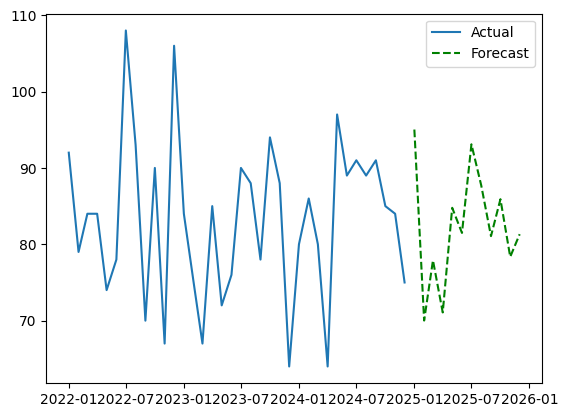

In [152]:
plt.plot(masked_df['ds'], masked_df['y'], label='Actual')
plt.plot(masked_df['ds'], masked_df['yhat'], label='Forecast', linestyle='--', color='green')
plt.legend()
plt.show()

In [153]:
actual_data = merged_df[masked_df['y'].notna()]
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(actual_data['y'], actual_data['yhat'])
print(f"MAE: {mae:.2f}")
avg_actual = actual_data['y'].mean()
print(f"Average actual monthly fill: {avg_actual:.2f}")
mape = (abs(actual_data['y'] - actual_data['yhat']) / actual_data['y']).mean() * 100
print(f"MAPE: {mape:.2f}%")

MAE: 5.04
Average actual monthly fill: 83.25
MAPE: 6.17%


In [154]:
claims_sorted.head(1)

,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region,previous_end,gap_days,new_start,last_med_date,todays_date,last_med_days_count,discontinued
1193,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South,NaN,-1.0,0,2024-10-12,2025-10-02,355,0


In [155]:
prescribers.head(1)

,hcp_id,specialty,brand_written,region
0,HCP7311,Endocrinology,Drug_E,South


In [156]:
calendar.head(1)

,date,month,year,fiscal_quarter,fiscal_year
0,2022-01-01,1,2022,1,2022


In [157]:
claims_sorted_snip=claims_sorted[['patient_id','start_date','end_date','days_supply','provider_id','previous_end','gap_days']]
claims_sorted_snip.head(3)
claims_sorted_snip = claims_sorted_snip.copy()

In [158]:
claims_sorted_snip['start_date'] = pd.to_datetime(claims_sorted_snip['start_date'])
calendar['date'] = pd.to_datetime(calendar['date'])
claims_mapped_1=claims_sorted_snip.merge(calendar[['date','fiscal_quarter','year']], how='left',left_on='start_date',right_on='date')
claims_mapped_1.head(2)

,patient_id,start_date,end_date,days_supply,provider_id,previous_end,gap_days,date,fiscal_quarter,year
0,P10074,2022-04-06,2022-07-05,90,HCP8043,NaN,-1.0,2022-04-06,2,2022
1,P10074,2022-06-26,2022-09-24,90,HCP7790,2022-07-05,-9.0,2022-06-26,2,2022


In [159]:
import pandas as pd
claims_mapped_1['start_date'] = pd.to_datetime(claims_mapped_1['start_date'])
claims_mapped_1['end_date'] = pd.to_datetime(claims_mapped_1['end_date'])
claims_mapped_1['total_days'] = (claims_mapped_1['end_date'] - claims_mapped_1['start_date']).dt.days + 1
claims_mapped_1['mid_date'] = claims_mapped_1['start_date'] + pd.to_timedelta(claims_mapped_1['total_days'] // 2, unit='D')
claims_mapped_1['fiscal_quarter'] = claims_mapped_1['mid_date'].dt.quarter
claims_mapped_1.drop(columns=['total_days', 'mid_date'], inplace=True)

In [160]:
claims_mapped_1.head(5)

,patient_id,start_date,end_date,days_supply,provider_id,previous_end,gap_days,date,fiscal_quarter,year
0,P10074,2022-04-06,2022-07-05,90,HCP8043,NaN,-1.0,2022-04-06,2,2022
1,P10074,2022-06-26,2022-09-24,90,HCP7790,2022-07-05,-9.0,2022-06-26,3,2022
2,P10074,2022-07-29,2022-08-28,30,HCP6344,2022-09-24,-57.0,2022-07-29,3,2022
3,P10074,2022-11-23,2023-02-21,90,HCP6067,2022-08-28,87.0,2022-11-23,1,2022
4,P10074,2023-08-21,2023-11-19,90,HCP1090,2023-02-21,181.0,2023-08-21,4,2023


In [161]:
claims_mapped_2 = claims_mapped_1.merge(
    prescribers,
    how='left',
    left_on='provider_id',
    right_on='hcp_id'
)
claims_mapped_2.head(3)

,patient_id,start_date,end_date,days_supply,provider_id,previous_end,gap_days,date,fiscal_quarter,year,hcp_id,specialty,brand_written,region
0,P10074,2022-04-06,2022-07-05,90,HCP8043,NaN,-1.0,2022-04-06,2,2022,HCP8043,Endocrinology,Drug_A,North
1,P10074,2022-06-26,2022-09-24,90,HCP7790,2022-07-05,-9.0,2022-06-26,3,2022,HCP7790,Neurology,Drug_E,North
2,P10074,2022-07-29,2022-08-28,30,HCP6344,2022-09-24,-57.0,2022-07-29,3,2022,HCP6344,General,Drug_B,North


In [162]:
claims_mapped_3=claims_mapped_2.groupby(['patient_id','year','fiscal_quarter','specialty','region','gap_days']).agg(fill_count=('start_date','nunique'),dos=('days_supply','sum')).reset_index()
claims_mapped_3.head(2)

,patient_id,year,fiscal_quarter,specialty,region,gap_days,fill_count,dos
0,P10074,2022,1,General,South,87.0,1,90
1,P10074,2022,2,Endocrinology,North,-1.0,1,90


In [163]:
claims_mapped_4=claims_mapped_3.groupby(['year','fiscal_quarter']).agg(fill_count=('fill_count','sum'),dos_quater=('dos','sum')).reset_index()
claims_mapped_4.head(2)

,year,fiscal_quarter,fill_count,dos_quater
0,2022,1,276,17280
1,2022,2,247,14640


In [164]:
claims_mapped_3.head(2)

,patient_id,year,fiscal_quarter,specialty,region,gap_days,fill_count,dos
0,P10074,2022,1,General,South,87.0,1,90
1,P10074,2022,2,Endocrinology,North,-1.0,1,90


In [165]:
claims_mapped_3['Time_frame'] = 90
claims_mapped_3.head(2)

,patient_id,year,fiscal_quarter,specialty,region,gap_days,fill_count,dos,Time_frame
0,P10074,2022,1,General,South,87.0,1,90,90
1,P10074,2022,2,Endocrinology,North,-1.0,1,90,90


In [166]:
claims_mapped_3['adherence'] = claims_mapped_3['dos'] / claims_mapped_3['Time_frame']
claims_mapped_3.head(5)

,patient_id,year,fiscal_quarter,specialty,region,gap_days,fill_count,dos,Time_frame,adherence
0,P10074,2022,1,General,South,87.0,1,90,90,1.000000
1,P10074,2022,2,Endocrinology,North,-1.0,1,90,90,1.000000
2,P10074,2022,3,General,North,-57.0,1,30,90,0.333333
3,P10074,2022,3,Neurology,North,-9.0,1,90,90,1.000000
4,P10074,2023,4,Cardiology,West,-46.0,1,30,90,0.333333


In [167]:
claims_mapped_3['specialty'] = claims_mapped_3['specialty'].astype(str)
claims_mapped_3['region'] = claims_mapped_3['region'].astype(str)

In [168]:
claims_encoded = pd.get_dummies(claims_mapped_3, columns=['specialty', 'region'])
dummy_columns = [col for col in claims_encoded.columns if col.startswith('specialty_') or col.startswith('region_')]
claims_encoded[dummy_columns] = claims_encoded[dummy_columns].astype(int)
claims_encoded.head(2)

,patient_id,year,fiscal_quarter,gap_days,fill_count,dos,Time_frame,adherence,specialty_Cardiology,specialty_Endocrinology,specialty_General,specialty_Neurology,region_East,region_North,region_South,region_West
0,P10074,2022,1,87.0,1,90,90,1.0,0,0,1,0,0,0,1,0
1,P10074,2022,2,-1.0,1,90,90,1.0,0,1,0,0,0,1,0,0


In [169]:
claims_encoded = claims_encoded.sort_values(['patient_id', 'year', 'fiscal_quarter'])
claims_encoded['target'] = claims_encoded.groupby('patient_id')['fill_count'].shift(-1)
claims_encoded['target'] = claims_encoded['target'].fillna(0)
claims_encoded['target'] = (claims_encoded['target'] > 0).astype(int)

In [170]:
claims_encoded.head(2)

,patient_id,year,fiscal_quarter,gap_days,fill_count,dos,Time_frame,adherence,specialty_Cardiology,specialty_Endocrinology,specialty_General,specialty_Neurology,region_East,region_North,region_South,region_West,target
0,P10074,2022,1,87.0,1,90,90,1.0,0,0,1,0,0,0,1,0,1
1,P10074,2022,2,-1.0,1,90,90,1.0,0,1,0,0,0,1,0,0,1


In [171]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb

In [172]:
X = claims_encoded.drop(columns=['patient_id', 'target'])
y = claims_encoded['target']
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (2999, 15)
Target vector shape: (2999,)


In [173]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Train set size: 2699
Test set size: 300


In [174]:
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)
print("XGBoost model training completed!")

XGBoost model training completed!


In [175]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", round(roc_auc, 4))

Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59        50
           1       0.91      0.93      0.92       250

    accuracy                           0.87       300
   macro avg       0.77      0.75      0.76       300
weighted avg       0.87      0.87      0.87       300

ROC-AUC Score: 0.8831


Top 10 Important Features:
 year                       0.492674
fiscal_quarter             0.089964
specialty_Cardiology       0.049942
gap_days                   0.048390
adherence                  0.043936
specialty_Neurology        0.043011
region_South               0.035775
region_North               0.034603
specialty_General          0.034391
specialty_Endocrinology    0.033744
dtype: float32


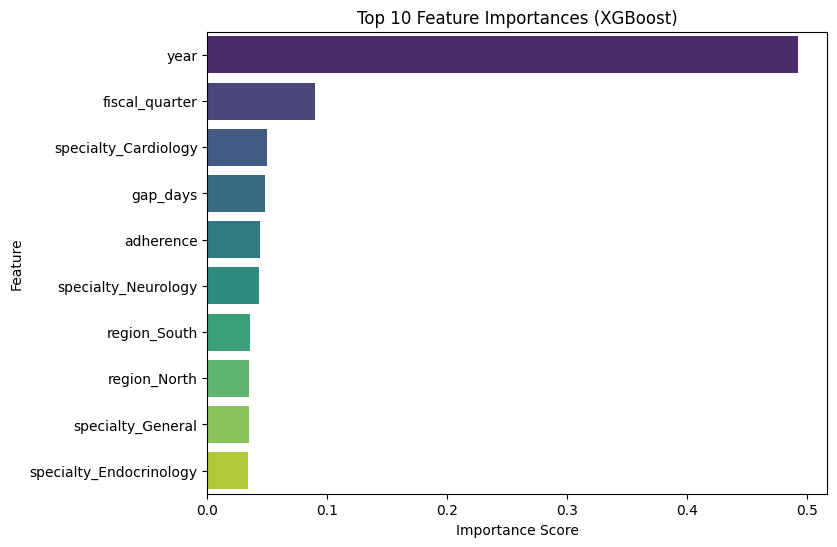

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)
print("Top 10 Important Features:\n", importances.head(10))
plt.figure(figsize=(8,6))
sns.barplot(x=importances.head(10), y=importances.head(10).index, palette="viridis")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [177]:
class_dist_table = y.value_counts().reset_index()
class_dist_table.columns = ['target_class', 'count']
class_dist_table['percent'] = round((class_dist_table['count'] / len(y)) * 100, 2)
display(class_dist_table)

,target_class,count,percent
0,1,2502,83.43
1,0,497,16.57


In [178]:
from sklearn.metrics import confusion_matrix
import pandas as pd
cm = confusion_matrix(y_test, y_pred)
cm_table = pd.DataFrame(cm,
                        index=['Actual_0 (No Refill)', 'Actual_1 (Refill)'],
                        columns=['Pred_0 (No Refill)', 'Pred_1 (Refill)'])
print("Confusion Matrix Table:")
display(cm_table)

Confusion Matrix Table:


,Pred_0 (No Refill),Pred_1 (Refill)
Actual_0 (No Refill),28,22
Actual_1 (Refill),17,233


In [179]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
y_pred_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred_thresh = (y_pred_proba >= threshold).astype(int)
cm_thresh = confusion_matrix(y_test, y_pred_thresh)
cm_thresh_table = pd.DataFrame(cm_thresh,
                               index=['Actual_0 (No Refill)', 'Actual_1 (Refill)'],
                               columns=['Pred_0 (No Refill)', 'Pred_1 (Refill)'])
print(f"Confusion Matrix with threshold = {threshold}:")
display(cm_thresh_table)
print("\nClassification Report with tuned threshold:")
print(classification_report(y_test, y_pred_thresh))

Confusion Matrix with threshold = 0.4:


,Pred_0 (No Refill),Pred_1 (Refill)
Actual_0 (No Refill),25,25
Actual_1 (Refill),13,237



Classification Report with tuned threshold:
              precision    recall  f1-score   support

           0       0.66      0.50      0.57        50
           1       0.90      0.95      0.93       250

    accuracy                           0.87       300
   macro avg       0.78      0.72      0.75       300
weighted avg       0.86      0.87      0.87       300



In [180]:
neg, pos = y.value_counts()[0], y.value_counts()[1]
scale_pos_weight = neg / pos
print("Scale_pos_weight:", scale_pos_weight)
model_weighted = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)
model_weighted.fit(X_train, y_train)
y_pred_weighted = model_weighted.predict(X_test)
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
cm_weighted_table = pd.DataFrame(cm_weighted,
    index=['Actual_0 (No Refill)', 'Actual_1 (Refill)'],
    columns=['Pred_0 (No Refill)', 'Pred_1 (Refill)'])
print("Confusion Matrix with Class Weights:")
display(cm_weighted_table)
print("\nClassification Report with Class Weights:")
print(classification_report(y_test, y_pred_weighted))

Scale_pos_weight: 0.19864108713029577
Confusion Matrix with Class Weights:


,Pred_0 (No Refill),Pred_1 (Refill)
Actual_0 (No Refill),39,11
Actual_1 (Refill),39,211



Classification Report with Class Weights:
              precision    recall  f1-score   support

           0       0.50      0.78      0.61        50
           1       0.95      0.84      0.89       250

    accuracy                           0.83       300
   macro avg       0.73      0.81      0.75       300
weighted avg       0.88      0.83      0.85       300



In [181]:
 from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def get_metrics(y_true, y_pred, label):
    return {
        'Model': label,
        'Accuracy': round(accuracy_score(y_true, y_pred), 3),
        'Precision_0': round(precision_score(y_true, y_pred, pos_label=0), 3),
        'Recall_0': round(recall_score(y_true, y_pred, pos_label=0), 3),
        'F1_0': round(f1_score(y_true, y_pred, pos_label=0), 3),
        'Precision_1': round(precision_score(y_true, y_pred, pos_label=1), 3),
        'Recall_1': round(recall_score(y_true, y_pred, pos_label=1), 3),
        'F1_1': round(f1_score(y_true, y_pred, pos_label=1), 3),
    }
results = []
results.append(get_metrics(y_test, y_pred, "Baseline (0.5 threshold)"))
results.append(get_metrics(y_test, y_pred_thresh, "Threshold = 0.4"))
results.append(get_metrics(y_test, y_pred_weighted, "Class Weights"))
results_table = pd.DataFrame(results)
display(results_table)

,Model,Accuracy,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
0,Baseline (0.5 threshold),0.870,0.622,0.56,0.589,0.914,0.932,0.923
1,Threshold = 0.4,0.873,0.658,0.50,0.568,0.905,0.948,0.926
2,Class Weights,0.833,0.500,0.78,0.609,0.950,0.844,0.894


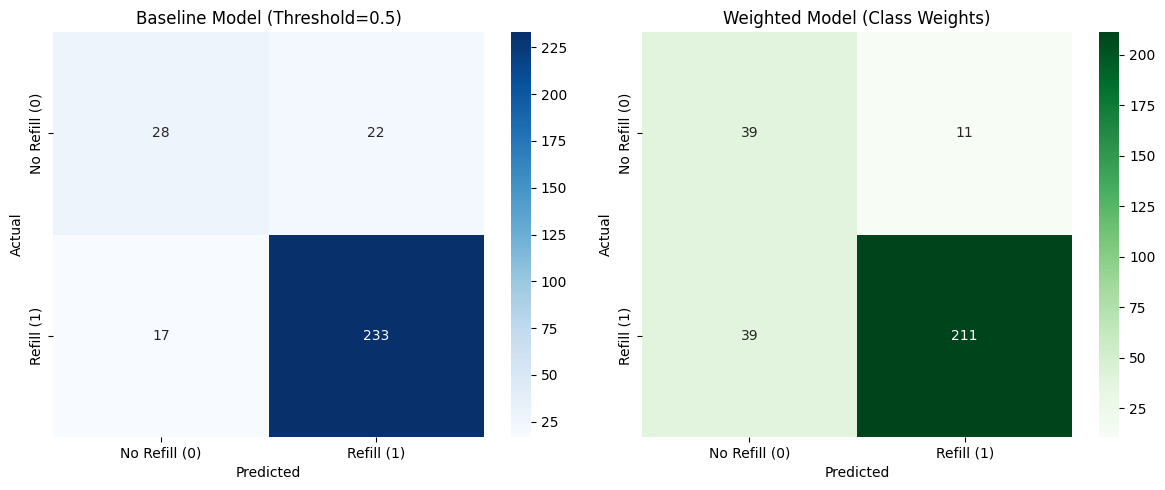

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm_baseline = confusion_matrix(y_test, y_pred)
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap="Blues", ax=axes[0])
axes[0].set_title("Baseline Model (Threshold=0.5)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_xticklabels(["No Refill (0)", "Refill (1)"])
axes[0].set_yticklabels(["No Refill (0)", "Refill (1)"])
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap="Greens", ax=axes[1])
axes[1].set_title("Weighted Model (Class Weights)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_xticklabels(["No Refill (0)", "Refill (1)"])
axes[1].set_yticklabels(["No Refill (0)", "Refill (1)"])
plt.tight_layout()
plt.show()

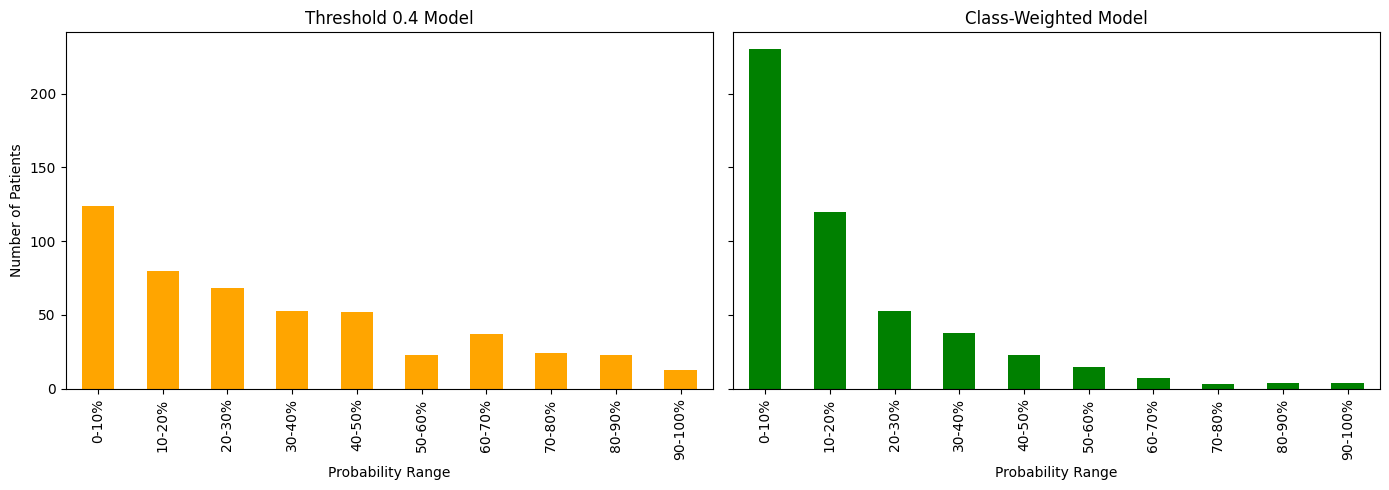

🔹 Patient counts by 10% probability bin (Threshold 0.4):
Bin_04
0-10%      124
10-20%      80
20-30%      68
30-40%      53
40-50%      52
50-60%      23
60-70%      37
70-80%      24
80-90%      23
90-100%     13
Name: count, dtype: int64

🔹 Patient counts by 10% probability bin (Class-Weighted):
Bin_WT
0-10%      230
10-20%     120
20-30%      53
30-40%      38
40-50%      23
50-60%      15
60-70%       7
70-80%       3
80-90%       4
90-100%      4
Name: count, dtype: int64


In [183]:
import pandas as pd
import matplotlib.pyplot as plt

latest_features = claims_mapped_3.sort_values(["patient_id","year","fiscal_quarter"])
latest_features = latest_features.groupby("patient_id").tail(1).reset_index(drop=True)

patient_final = pd.get_dummies(latest_features, columns=['specialty','region'])

train_cols = [col for col in claims_encoded.columns if col not in ["target","patient_id"]]

for col in train_cols:
    if col not in patient_final.columns:
        patient_final[col] = 0

patient_final = patient_final[train_cols]

patient_probs_04 = model.predict_proba(patient_final)[:, 1]

patient_probs_wt = model_weighted.predict_proba(patient_final)[:, 1]

bins = list(range(0, 101, 10))
labels = [f"{i}-{i+10}%" for i in bins[:-1]]

prob_compare = pd.DataFrame({
    "Prob_04": (patient_probs_04*100),
    "Prob_WT": (patient_probs_wt*100)
})

prob_compare["Bin_04"] = pd.cut(prob_compare["Prob_04"], bins=bins, labels=labels, include_lowest=True)
prob_compare["Bin_WT"] = pd.cut(prob_compare["Prob_WT"], bins=bins, labels=labels, include_lowest=True)

bin_summary_04 = prob_compare["Bin_04"].value_counts().sort_index()
bin_summary_WT = prob_compare["Bin_WT"].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

bin_summary_04.plot(kind="bar", ax=axes[0], color="orange")
axes[0].set_title("Threshold 0.4 Model")
axes[0].set_xlabel("Probability Range")
axes[0].set_ylabel("Number of Patients")

bin_summary_WT.plot(kind="bar", ax=axes[1], color="green")
axes[1].set_title("Class-Weighted Model")
axes[1].set_xlabel("Probability Range")

plt.tight_layout()
plt.show()

print("🔹 Patient counts by 10% probability bin (Threshold 0.4):")
print(bin_summary_04)

print("\n🔹 Patient counts by 10% probability bin (Class-Weighted):")
print(bin_summary_WT)


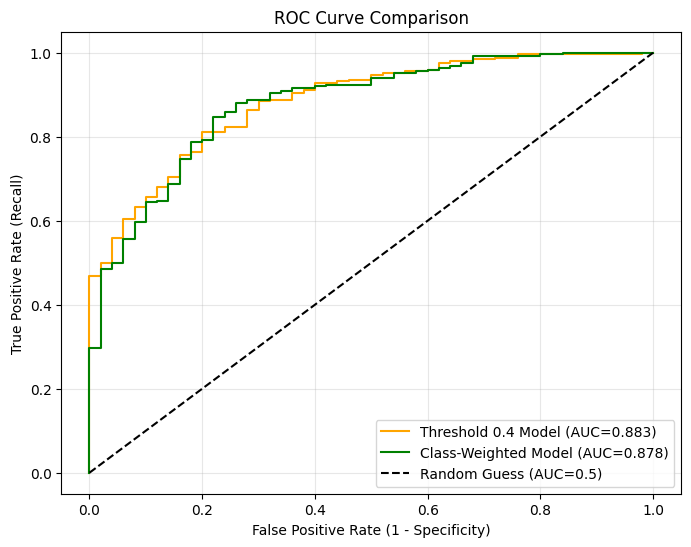

ROC–AUC (Threshold 0.4 model): 0.883
ROC–AUC (Class-Weighted model): 0.878


In [184]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_proba_04 = model.predict_proba(X_test)[:, 1]        # base model
y_pred_04 = (y_proba_04 >= 0.4).astype(int)

y_proba_wt = model_weighted.predict_proba(X_test)[:, 1]   # weighted model
y_pred_wt = (y_proba_wt >= 0.5).astype(int)

fpr_04, tpr_04, _ = roc_curve(y_test, y_proba_04)
fpr_wt, tpr_wt, _ = roc_curve(y_test, y_proba_wt)

auc_04 = roc_auc_score(y_test, y_proba_04)
auc_wt = roc_auc_score(y_test, y_proba_wt)

plt.figure(figsize=(8,6))
plt.plot(fpr_04, tpr_04, label=f"Threshold 0.4 Model (AUC={auc_04:.3f})", color="orange")
plt.plot(fpr_wt, tpr_wt, label=f"Class-Weighted Model (AUC={auc_wt:.3f})", color="green")
plt.plot([0,1], [0,1], 'k--', label="Random Guess (AUC=0.5)")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"ROC–AUC (Threshold 0.4 model): {auc_04:.3f}")
print(f"ROC–AUC (Class-Weighted model): {auc_wt:.3f}")


In [185]:

print("=== Market Lookup Data ===")
print(market.columns.tolist())
print(market.head(), "\n")

print("=== Prescribers Data ===")
print(prescribers.columns.tolist())
print(prescribers.head(), "\n")

print("=== Claims Data ===")
print(claims.columns.tolist())
print(claims.head(), "\n")

print("=== Calendar Data ===")
print(calendar.columns.tolist())
print(calendar.head(), "\n")


=== Market Lookup Data ===
['brand_name', 'molecule', 'therapeutic_class']
  brand_name    molecule therapeutic_class
0     Drug_A  Molecule_0           Class_A
1     Drug_B  Molecule_1           Class_B
2     Drug_C  Molecule_2           Class_C
3     Drug_D  Molecule_3           Class_A
4     Drug_E  Molecule_4           Class_B 

=== Prescribers Data ===
['hcp_id', 'specialty', 'brand_written', 'region']
    hcp_id      specialty brand_written region
0  HCP7311  Endocrinology        Drug_E  South
1  HCP4114        General        Drug_E  South
2  HCP5173      Neurology        Drug_E   East
3  HCP1727      Neurology        Drug_E   West
4  HCP8144     Cardiology        Drug_C  North 

=== Claims Data ===
['patient_id', 'ndc_code', 'drug_name', 'start_date', 'end_date', 'days_supply', 'provider_id', 'specialty', 'diagnosis_code', 'region']
  patient_id    ndc_code drug_name  start_date    end_date  days_supply  \
0     P23104  51904-9849    Drug_B  2022-05-12  2022-07-11           60  

In [186]:
import pandas as pd

claims["start_date"] = pd.to_datetime(claims["start_date"])
claims["end_date"] = pd.to_datetime(claims["end_date"])

patient_span = claims.groupby("patient_id").agg(
    min_date=("start_date", "min"),
    max_date=("end_date", "max")
).reset_index()

patient_span["years_of_data"] = (patient_span["max_date"] - patient_span["min_date"]).dt.days / 365.25

total_patients = patient_span["patient_id"].nunique()
avg_years = patient_span["years_of_data"].mean()
max_years = patient_span["years_of_data"].max()

print(f"Total distinct patients: {total_patients}")
print(f"Average years of data per patient: {avg_years:.2f}")
print(f"Maximum years of data for any patient: {max_years:.2f}")


patient_span.head(10)


Total distinct patients: 497
Average years of data per patient: 2.21
Maximum years of data for any patient: 3.23


,patient_id,min_date,max_date,years_of_data
0,P10074,2022-04-06,2024-10-12,2.518823
1,P10282,2022-08-15,2025-02-19,2.516085
2,P10425,2022-05-26,2024-11-22,2.494182
3,P10464,2023-03-01,2024-06-28,1.327858
4,P10851,2022-01-27,2024-12-15,2.882957
5,P10942,2022-03-17,2024-03-30,2.036961
6,P11025,2023-02-23,2024-06-29,1.347023
7,P11220,2022-01-14,2024-12-06,2.893908
8,P11267,2022-01-29,2023-04-24,1.232033
9,P11504,2023-06-25,2024-05-04,0.859685
